In [7]:
# Import required libraries
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory


In [9]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2023-11-29 01:09:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2023-11-29 01:09:29 (15.2 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



## Downloading and preprocessing the data

In [10]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir


In [11]:
!kaggle datasets download -d sujaykapadnis/smoking

 89% 57.0M/63.8M [00:01<00:00, 50.1MB/s]
100% 63.8M/63.8M [00:01<00:00, 47.2MB/s]


In [12]:
unzip_data('/content/smoking.zip')
train_dir = '/content/Training/Training'
test_dir = '/content/Testing/Testing'
val_dir = '/content/Validation/Validation'

In [13]:
walk_through_dir('/content/Training')

There are 1 directories and 0 images in '/content/Training'.
There are 0 directories and 716 images in '/content/Training/Training'.


In [14]:
walk_through_dir('/content/Testing')

There are 1 directories and 0 images in '/content/Testing'.
There are 0 directories and 224 images in '/content/Testing/Testing'.


In [15]:
walk_through_dir('/content/Validation')

There are 1 directories and 0 images in '/content/Validation'.
There are 0 directories and 180 images in '/content/Validation/Validation'.


In [16]:
import os
import shutil

def organize_images_for_tensorflow(train_dir, test_dir, top_level_folder):
    """
    Organize images into 'smoker' and 'notSmoker' subfolders for TensorFlow.

    Parameters:
    - train_dir (str): Training data directory.
    - test_dir (str): Testing data directory.
    - top_level_folder (str): Top-level folder to organize the data.
    """
    # Create top-level folder if it doesn't exist
    os.makedirs(top_level_folder, exist_ok=True)

    # Define subfolders for 'train' and 'test'
    train_folder = os.path.join(top_level_folder, 'train')
    test_folder = os.path.join(top_level_folder, 'test')

    # Create subfolders if they don't exist
    for folder in [train_folder, test_folder]:
        os.makedirs(folder, exist_ok=True)

    # Define subfolders for 'smoker' and 'notSmoker' within 'train' and 'test'
    train_smoker_folder = os.path.join(train_folder, 'smoker')
    train_not_smoker_folder = os.path.join(train_folder, 'notSmoker')
    test_smoker_folder = os.path.join(test_folder, 'smoker')
    test_not_smoker_folder = os.path.join(test_folder, 'notSmoker')

    # Create subfolders if they don't exist
    for folder in [train_smoker_folder, train_not_smoker_folder, test_smoker_folder, test_not_smoker_folder]:
        os.makedirs(folder, exist_ok=True)

    # Function to move images to appropriate subfolder
    def move_images_to_subfolder(src_folder, dest_folder, class_name):
        for filename in os.listdir(src_folder):
            if filename.lower().startswith(class_name.lower()):
                source_path = os.path.join(src_folder, filename)
                destination_path = os.path.join(dest_folder, filename)
                shutil.copy(source_path, destination_path)

    # Move images from training directory to 'train' subfolders
    move_images_to_subfolder(train_dir, train_smoker_folder, 'smoking')
    move_images_to_subfolder(train_dir, train_not_smoker_folder, 'notSmoking')

    # Move images from testing directory to 'test' subfolders
    move_images_to_subfolder(test_dir, test_smoker_folder, 'smoking')
    move_images_to_subfolder(test_dir, test_not_smoker_folder, 'notSmoking')

# Example usage:
train_dir = '/content/Training/Training'
test_dir = '/content/Testing/Testing'
top_level_folder = '/content/SmokerDetectionDataset'

organize_images_for_tensorflow(train_dir, test_dir, top_level_folder)

In [17]:
walk_through_dir('/content/SmokerDetectionDataset')

There are 2 directories and 0 images in '/content/SmokerDetectionDataset'.
There are 2 directories and 0 images in '/content/SmokerDetectionDataset/test'.
There are 0 directories and 112 images in '/content/SmokerDetectionDataset/test/smoker'.
There are 0 directories and 112 images in '/content/SmokerDetectionDataset/test/notSmoker'.
There are 2 directories and 0 images in '/content/SmokerDetectionDataset/train'.
There are 0 directories and 358 images in '/content/SmokerDetectionDataset/train/smoker'.
There are 0 directories and 358 images in '/content/SmokerDetectionDataset/train/notSmoker'.


In [39]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

# Now smoking and notSMoking images are under the same parent folder
final_train_dir = '/content/SmokerDetectionDataset/train'
final_test_dir = '/content/SmokerDetectionDataset/test'

train_data = tf.keras.preprocessing.image_dataset_from_directory(final_train_dir,
                                                                                label_mode="binary",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(final_test_dir,
                                                                label_mode="binary",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis


Found 716 files belonging to 2 classes.
Found 224 files belonging to 2 classes.


## Show images

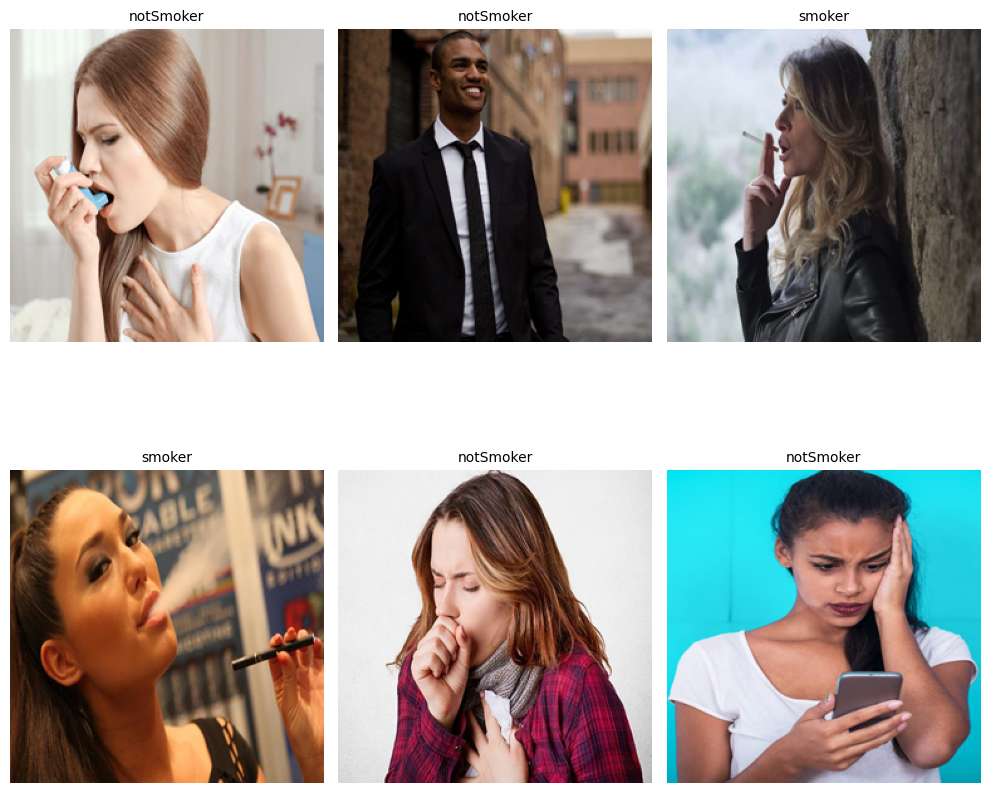

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

def display_random_image_grid_with_labels(folder_path, num_rows, num_cols):
    """
    Display a grid of randomly selected images from subfolders with labels.

    Parameters:
    - folder_path (str): Path to the folder containing subfolders with images.
    - num_rows (int): Number of rows in the grid.
    - num_cols (int): Number of columns in the grid.
    """
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

    # Get a list of subfolders (class labels)
    class_labels = [subfolder for subfolder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, subfolder))]

    for i in range(num_rows):
        for j in range(num_cols):
            class_label = random.choice(class_labels)
            class_folder_path = os.path.join(folder_path, class_label)

            # Get a list of image files in the selected subfolder
            image_files = [f for f in os.listdir(class_folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            if image_files:
                # Shuffle the list of image files
                random.shuffle(image_files)

                # Select a random image to display
                img_path = os.path.join(class_folder_path, random.choice(image_files))
                img = mpimg.imread(img_path)
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                axes[i, j].set_title(class_label, fontsize=10)

    plt.tight_layout()
    plt.show()

# Example usage:
folder_path = '/content/SmokerDetectionDataset/train'
num_rows = 2
num_cols = 3

display_random_image_grid_with_labels(folder_path, num_rows, num_cols)


In [20]:
# Create a checkpoint callback to save model
checkpoint_path = 'SmokerDetection_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

## Create data augmentation

In [106]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  #preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

## Create a base model

In [40]:
class_names = train_data.class_names
len(class_names)

2

In [43]:
for images, labels in train_data.take(1):
    labels = tf.squeeze(labels, axis=1)
    print("Shape of labels:", labels.shape)
    print("Sample labels:", labels.numpy())

Shape of labels: (32,)
Sample labels: [1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0.
 0. 1. 1. 1. 0. 0. 1. 0.]


In [24]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture
inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='global_avg_pooling')(x)
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)


16705208/16705208 [==============================] - 0s 0us/step


In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pooling (Global  (None, 1280)              0         
 AveragePooling2D)                                               
                                                                 
 output_layer (Dense)        (None, 1)                 1281      
                                                             

In [26]:
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history_model = model.fit(
    train_data,
    epochs=5,
    validation_data=test_data,
    validation_steps=len(test_data),
  callbacks=[checkpoint_callback]
)

Epoch 1/5
23/23 [==============================] - 86s 3s/step - loss: 0.6110 - accuracy: 0.6872 - val_loss: 0.4458 - val_accuracy: 0.8571
Epoch 2/5
23/23 [==============================] - 72s 3s/step - loss: 0.4962 - accuracy: 0.8128 - val_loss: 0.3604 - val_accuracy: 0.8929
Epoch 3/5
23/23 [==============================] - 75s 3s/step - loss: 0.4506 - accuracy: 0.8212 - val_loss: 0.3070 - val_accuracy: 0.9062
Epoch 4/5
23/23 [==============================] - 73s 3s/step - loss: 0.4193 - accuracy: 0.8324 - val_loss: 0.2918 - val_accuracy: 0.9062
Epoch 5/5
23/23 [==============================] - 67s 3s/step - loss: 0.3989 - accuracy: 0.8338 - val_loss: 0.2723 - val_accuracy: 0.9152


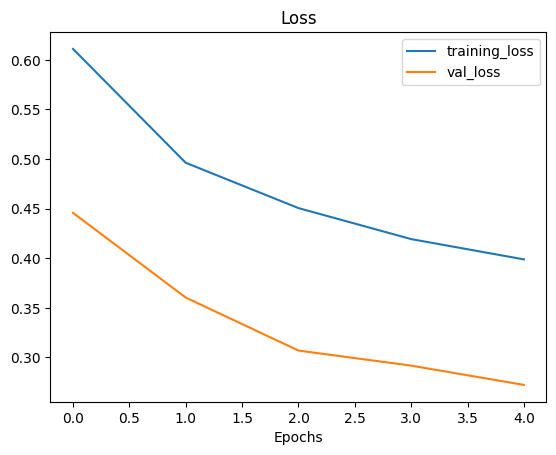

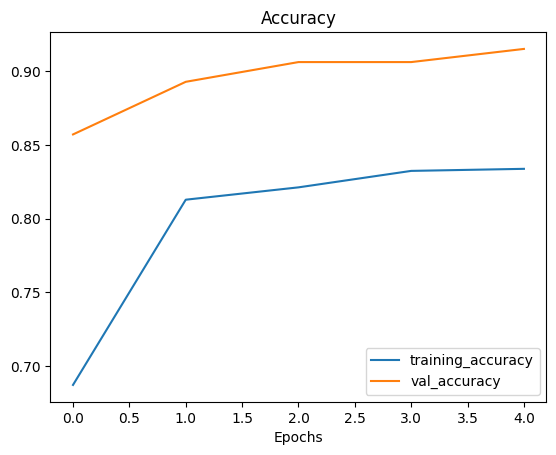

In [27]:
plot_loss_curves(history_model)

## Fine tunning

In [28]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False


In [29]:
# Recompile model with lower learning rate
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [30]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [31]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_model_fine_tune = model.fit(train_data,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps= len(test_data), # validate on 15% of the test data
                                                     initial_epoch=history_model.epoch[-1]) # start from previous last epoch


Epoch 5/10
23/23 [==============================] - 88s 3s/step - loss: 0.3535 - accuracy: 0.8603 - val_loss: 0.2194 - val_accuracy: 0.9375
Epoch 6/10
23/23 [==============================] - 104s 5s/step - loss: 0.3273 - accuracy: 0.8841 - val_loss: 0.2294 - val_accuracy: 0.9152
Epoch 7/10
23/23 [==============================] - 77s 3s/step - loss: 0.2755 - accuracy: 0.9078 - val_loss: 0.1877 - val_accuracy: 0.9241
Epoch 8/10
23/23 [==============================] - 70s 3s/step - loss: 0.2758 - accuracy: 0.8883 - val_loss: 0.1650 - val_accuracy: 0.9464
Epoch 9/10
23/23 [==============================] - 72s 3s/step - loss: 0.2785 - accuracy: 0.8841 - val_loss: 0.1729 - val_accuracy: 0.9420
Epoch 10/10
23/23 [==============================] - 73s 3s/step - loss: 0.2300 - accuracy: 0.9176 - val_loss: 0.2016 - val_accuracy: 0.9107


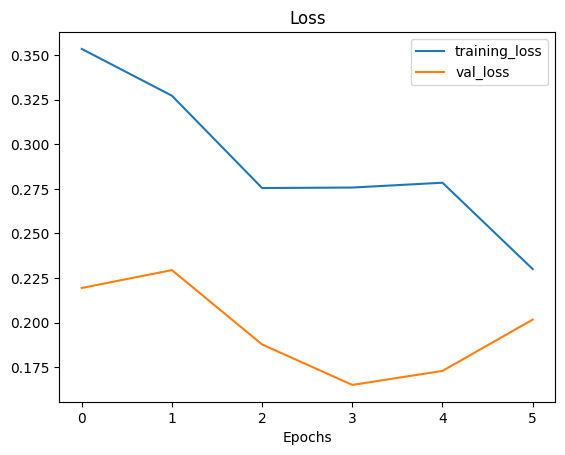

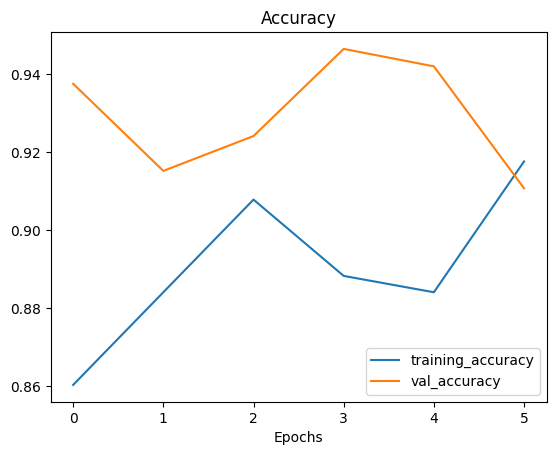

In [32]:
plot_loss_curves(history_model_fine_tune)

In [35]:
results_model_fine_tunning = model.evaluate(test_data)
results_model_fine_tunning

7/7 [==============================] - 16s 2s/step - loss: 0.2016 - accuracy: 0.9107


[0.20164203643798828, 0.9107142686843872]

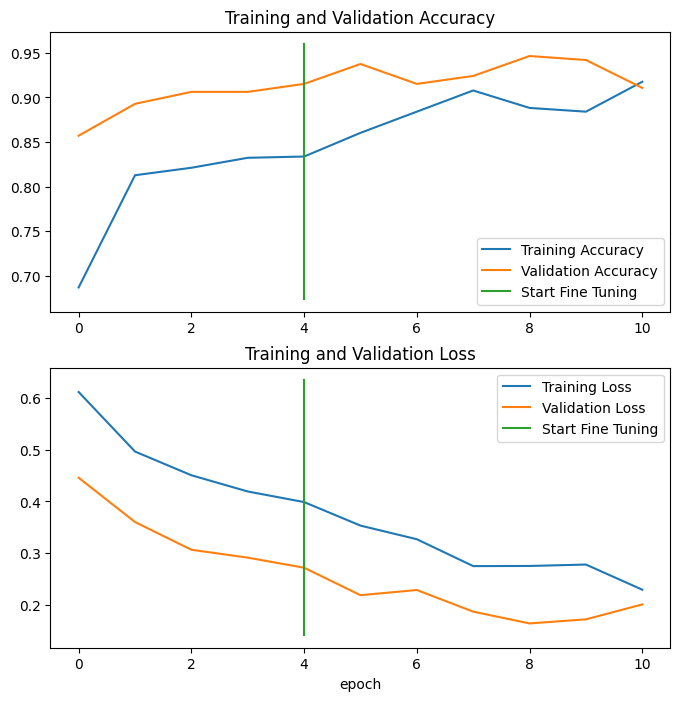

In [34]:
compare_historys(original_history=history_model,
                 new_history=history_model_fine_tune,
                 initial_epochs = 5)

## Making predictions with our model

In [36]:
model_pred_probs = model.predict(test_data)
model_pred_probs.shape

7/7 [==============================] - 20s 2s/step


(224, 1)

In [37]:

# How do they look?
model_pred_probs[:10]

array([[0.4445782 ],
       [0.37913448],
       [0.02696149],
       [0.59354216],
       [0.02890855],
       [0.13892949],
       [0.899795  ],
       [0.0024331 ],
       [0.00665886],
       [0.06639417]], dtype=float32)

In [93]:
# We can index the predicted class by rounding the prediction probability
pred_class = class_names[int(tf.round(model_pred_probs)[0][0])]
pred_class

'notSmoker'

In [95]:
threshold = 0.5  # You can adjust this threshold based on your needs
model_preds = (model_pred_probs > threshold).astype(int)
model_preds[:50]

array([[0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0]])

In [97]:
threshold = 0.5  # You can adjust this threshold based on your needs

# create y_labels
y_labels = []

for images, labels in test_data.unbatch():
    model_preds = (model_pred_probs > threshold).astype(int)
    y_labels.append(model_preds)

y_labels[:10]


[array([[0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],

In [62]:
len(y_labels)

224

## Evaluating our models predictions

In [51]:
from helper_functions import make_confusion_matrix

In [63]:
class_names = test_data.class_names

['notSmoker', 'smoker']

In [66]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

/content/SmokerDetectionDataset/test/smoker/smoking_0071.jpg
1/1 [==============================] - 0s 78ms/step
/content/SmokerDetectionDataset/test/notSmoker/notsmoking_0329.jpg
1/1 [==============================] - 0s 77ms/step
/content/SmokerDetectionDataset/test/smoker/smoking_0464.jpg
1/1 [==============================] - 0s 83ms/step


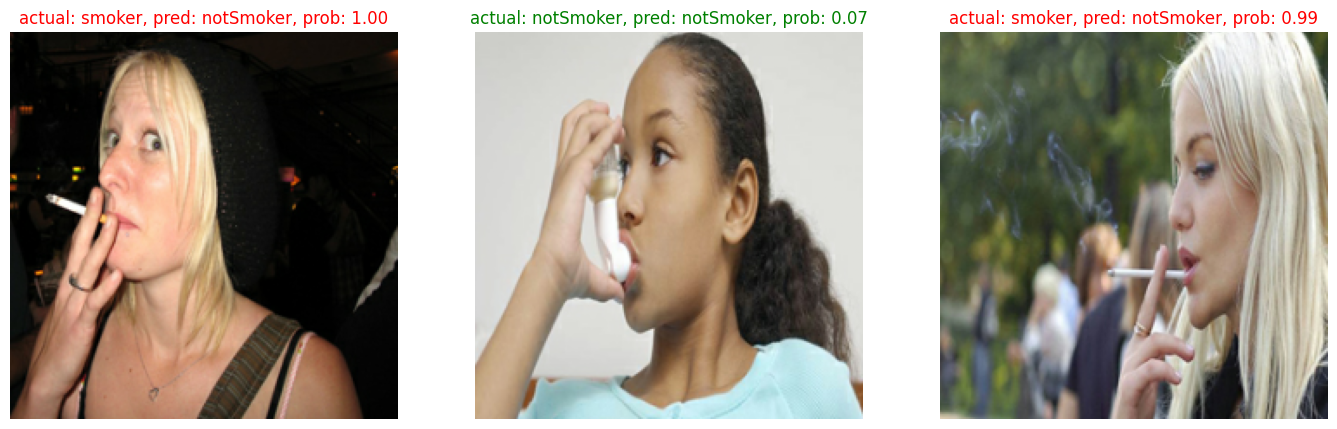

In [99]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(final_test_dir + "/" + class_name))
  filepath = final_test_dir +"/" + class_name + "/" + filename
  print(filepath)

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

Our model is only predicting for 1 class. Lets create anoter less complex model

## Model 1

In [107]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=0.2, # rotate the image slightly
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.)

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)


In [120]:

# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(final_train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=True)

# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(final_train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=True) #

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(final_test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')


Augmented training images:
Found 716 images belonging to 2 classes.
Non-augmented training images:
Found 716 images belonging to 2 classes.
Unchanged test images:
Found 224 images belonging to 2 classes.


In [121]:

# Get a sample of the training data batch
images, labels = train_data.next() # get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

In [122]:
# Get the first two images
images[:2], images[0].shape

(array([[[[0.93725497, 0.8862746 , 0.95294124],
          [0.9450981 , 0.8941177 , 0.9607844 ],
          [0.9450981 , 0.8941177 , 0.9607844 ],
          ...,
          [0.9921569 , 0.96470594, 0.9921569 ],
          [0.9921569 , 0.96470594, 0.9921569 ],
          [0.9921569 , 0.96470594, 0.9921569 ]],
 
         [[0.94117653, 0.89019614, 0.9568628 ],
          [0.9450981 , 0.8941177 , 0.9607844 ],
          [0.9450981 , 0.8941177 , 0.9607844 ],
          ...,
          [0.9921569 , 0.96470594, 0.9921569 ],
          [0.9921569 , 0.96470594, 0.9921569 ],
          [0.9921569 , 0.96470594, 0.9921569 ]],
 
         [[0.93725497, 0.8862746 , 0.95294124],
          [0.94117653, 0.89019614, 0.9568628 ],
          [0.94117653, 0.89019614, 0.9568628 ],
          ...,
          [0.9921569 , 0.96470594, 0.9921569 ],
          [0.9921569 , 0.96470594, 0.9921569 ],
          [0.9921569 , 0.96470594, 0.9921569 ]],
 
         ...,
 
         [[0.6039216 , 0.5568628 , 0.6039216 ],
          [0.60784

In [124]:
for label in labels:
  if label == 1:
    print(label)



1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [125]:
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, Dense
# Create a CNN model (same as Tiny VGG but for binary classification - https://poloclub.github.io/cnn-explainer/ )
model_1 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)), # same input shape as our images
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_model_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
23/23 [==============================] - 48s 2s/step - loss: 0.6581 - accuracy: 0.5922 - val_loss: 0.5902 - val_accuracy: 0.7009
Epoch 2/5
23/23 [==============================] - 51s 2s/step - loss: 0.5786 - accuracy: 0.6969 - val_loss: 0.5746 - val_accuracy: 0.7143
Epoch 3/5
23/23 [==============================] - 56s 2s/step - loss: 0.5452 - accuracy: 0.7277 - val_loss: 0.5663 - val_accuracy: 0.6964
Epoch 4/5
23/23 [==============================] - 47s 2s/step - loss: 0.5163 - accuracy: 0.7458 - val_loss: 0.5481 - val_accuracy: 0.7321
Epoch 5/5
23/23 [==============================] - 52s 2s/step - loss: 0.4927 - accuracy: 0.7737 - val_loss: 0.5323 - val_accuracy: 0.7188


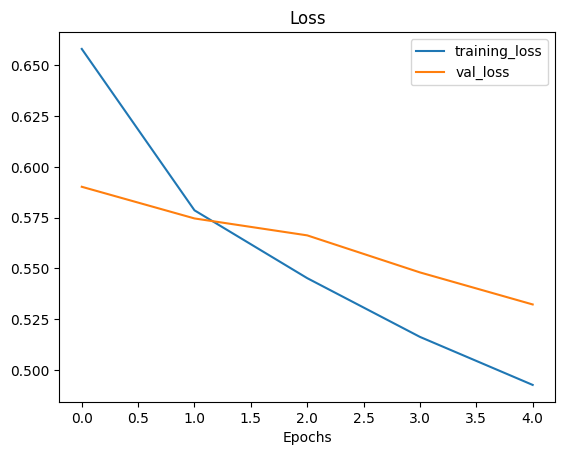

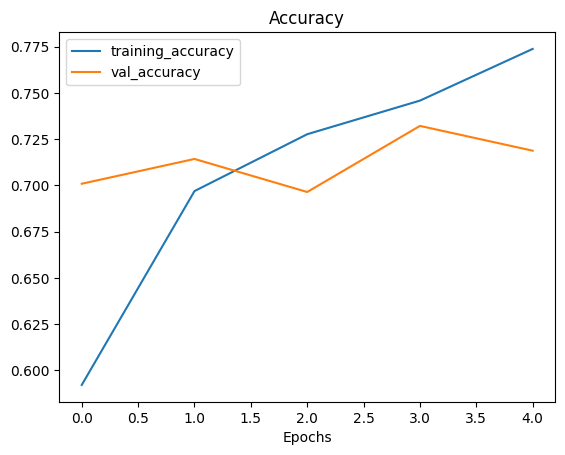

In [126]:
plot_loss_curves(history_model_1)

In [127]:
# Get data batch samples
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the same

